In [58]:
import numpy as np
import pandas as pd
import glob
import os
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from folium.plugins import MarkerCluster

In [59]:
###     Load Population Data    ###
folder_path = "Data/Palisades-Population"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df_pop = pd.concat(df_list, ignore_index=True)
df_pop['geometry'] = df_pop.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df_pop = df_pop.drop(columns=['country'])
gdf_pop = gpd.GeoDataFrame(df_pop, geometry='geometry')
gdf_pop = gdf_pop.set_crs(epsg=4326, inplace=True)

###     Load Movement Data    ###
folder_path = "Data/Palisades-Movement"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df_mov = pd.concat(df_list, ignore_index=True)
df_mov = df_mov.drop(columns=['country'])

###     Load Damage Data    ###
filepath = 'Data/Damage-Data.csv'
df_damage = pd.read_csv(filepath, index_col=0)
df_damage.columns = df_damage.columns.str.replace('*', '', regex=False).str.strip()
df_damage = df_damage[df_damage['Incident Name'] == 'Palisades']

# outline DAMAGE columns to keep
columns_to_keep = ['OBJECTID', 'Damage', 'City', 'Incident Start Date', 'Structure Type', 
                   'Year Built (parcel)', 'Latitude', 'Longitude']
df_damage = df_damage[columns_to_keep]

df_damage['geometry'] = df_damage.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_damage = gpd.GeoDataFrame(df_damage, geometry='geometry')
gdf_damage = gdf_damage.set_crs(epsg=4326, inplace=True)

# Reproject to EPSG:3857 (meters)
gdf_damage_proj = gdf_damage.to_crs(epsg=3857)
gdf_pop_proj = gdf_pop.to_crs(epsg=3857)

# Get total bounding box of all damage points
minx, miny, maxx, maxy = gdf_damage_proj.total_bounds

# Expand bounding box by 2km in all directions
buffer_meters = 2000
minx -= buffer_meters
miny -= buffer_meters
maxx += buffer_meters
maxy += buffer_meters

# Create expanded bounding box geometry
bounding_box = box(minx, miny, maxx, maxy)

# Filter population points within bounding box
gdf_pop_filtered = gdf_pop_proj[gdf_pop_proj.geometry.within(bounding_box)]

# Reproject back to EPSG:4326 if needed
gdf_pop = gdf_pop_filtered.to_crs(epsg=4326)
# 1m 37.9s

/var/folders/bl/pvtpksj10335mn0ydr2gpj4m0000gn/T/ipykernel_15279/2277836304.py:24: DtypeWarning: Columns (13,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_damage = pd.read_csv(filepath, index_col=0)


### Check-Work Code

Average distance to nearest neighbor: 2.02 km


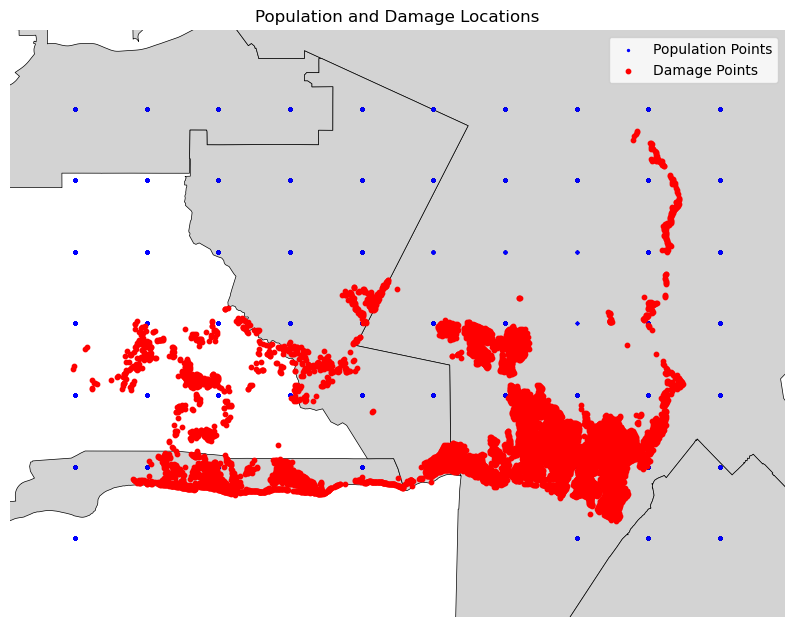

In [73]:
from sklearn.neighbors import BallTree

# Step 1: Drop duplicates and convert to numpy
coords = gdf_pop[['latitude', 'longitude']].drop_duplicates().to_numpy()
coords_rad = np.radians(coords)

# Step 2: BallTree with haversine distance
tree = BallTree(coords_rad, metric='haversine')
distances, _ = tree.query(coords_rad, k=2)  # self + nearest

# Step 3: Convert to kilometers
nearest_distances_km = distances[:, 1] * 6371

# Step 4: Compute average
average_distance_km = nearest_distances_km.mean()
print(f"Average distance to nearest neighbor: {average_distance_km:.2f} km")


gdf_basemap = gpd.read_file("CA_Places.shp")
gdf_basemap.set_crs(epsg=3857, inplace=True)
gdf_basemap = gdf_basemap.to_crs(gdf_pop.crs)

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot basemap
gdf_basemap.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

# Plot population points
gdf_pop.plot(ax=ax, color='blue', markersize=2, label='Population Points')

# Plot damage points
gdf_damage.plot(ax=ax, color='red', markersize=10, label='Damage Points')

# Customize
ax.set_title("Population and Damage Locations")
# Get bounds of gdf_pop
minx, miny, maxx, maxy = gdf_pop.total_bounds

lat_buffer = 0.02     # ~2.2 km
lon_buffer = 0.02     # ~1.7–2.2 km depending on latitude

# Set axis limits
ax.set_xlim(minx - lon_buffer, maxx + lon_buffer)
ax.set_ylim(miny - lat_buffer, maxy + lat_buffer)
ax.legend()
ax.set_axis_off()
